## **Brain Tumor Detection with VGG-16 Model**

Auteur : **DJHONSON JEAN**

Date : **Mars 2020**

== = == = == = == == = ==

# [Résumé](http://)

Le cancer du cerveau est aujourd'hui parmi les types de cancer les plus critiques. Plusieurs symptômes peuvent apparaitre en fonction de la localisation du cancer dans le cerveau. Sa détection précoce peut donner une nouvelle chance de vie, en suivant un traitement efficace a ce effet. Le but de ce travail, est d'utiliser une méthode d'apprentissage en profondeur (Deep Learning) pour detecter des tumeurs cancéreuses dans le cerveau à partir d'images IRM à l'aide d'un traitement sur l'image puis la classification de la tumeur avec les réseaux de neurones convolutifs (CNN)

# [1.- Contexte et Objectifs](http://)

Les  methodes rapides de detection de tumeurs cérébraux sont  l'imagerie par résonance magnétique (IRM). Cette méthode utilise d'imagerie médicale de haute qualité. Cependant, les techniques de détection du cancer doivent être fiables et robustes pour que les diagnostics soient corrects. À cette fin, l’objectif de ce projet est de construire un modèle CNN pouvant classer si le sujet avait une tumeur ou non sur la base de l'IRM. Pour se faire, on va utiliser l'architecture et les poids du modèle VGG-16 pour former le modèle à ce problème binaire. On utilisera la précision comme métrique pour justifier les performances du modèle qui peuvent être définies comme:

Accuracy= (Number of correclty predicted images / 
                  Total number of tested images) ×100%

# [1.1.- Description du Dataset](http://)
Les donnees utilisees pour resoudre notre probleme sont les images IRM cerebrales [Brain MRI Images for Brain Tumor Detection](http://www.kaggle.com/jjprotube/brainmriimagesforbraintumordetection) qui comprend des scanners IRM classes ainsi :

> NO - Pas de tumeur, code 0

> YES - Tumeur, code 1

Apres des recherches, on ne peut pas trouver une description valable pour le jeu de donnees et sur la provenance des analyses IRM

# [1.2.- C'est quoi une tumeur cérébrale?](http://)

Elle se produit lorsque des cellules anormales qui se forment dans le cerveau. Il existe en deux principaux types : les [tumeurs cancéreuses (malignes)](http://www.doctissimo.fr/sante/dictionnaire-medical/tumeur-maligne) et les [tumeurs bénignes](http://fr.wikipedia.org/wiki/Tumeur_bénigne). Les tumeurs cancéreuses peuvent être divisées en tumeurs primaires, qui commencent dans le cerveau, et en tumeurs secondaires, qui se sont propagées ailleurs, appelées tumeurs métastatiques cérébrales. Les divers symptômes du cancer du cerveau incluent des problèmes de coordination, des maux de tête fréquents, des sautes d'humeur, des changements d'élocution, des difficultés de concentration, des convulsions et une perte de  mémoire, qui dépendent de  la taille de la tumeur, de sa nature et de son emplacement. Le mal de tête est classiquement pire le matin et disparaît avec des vomissements. D'autres symptômes peuvent inclure des difficultés à marcher, à parler ou à ressentir des sensations. À mesure que la maladie progresse, une perte de conscience peut survenir.

Il est beaucoup plus facile d’éliminer les petites tumeurs. Une fois les symptômes  apparus, il  est généralement trop tard pour traiter la tumeur. Cependant, il est très difficile de traiter le cancer à des stades plus élevés où les taux de sur-vie sont faibles.

![](https://drive.google.com/drive/u/0/folders/1D92ZoPCohFbaO3sg0BqmK6yuQcYJBY_P)


> **Fig. 1**: Métastases cérébrales dans l'hémisphère cérébral droit du cancer du poumon, montrées sur l'imagerie par résonance magnétique.

# [2. Acquisition des Bibliotheques et Configuration](http://)

In [0]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [0]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

Using TensorFlow backend.


Une fois chargee, les images sont enregistrees dans un dossier avec des sous-dossier nommee oui et non. Donc, on divise les donnees en TRAIN, VAL et TEST afin de faciliter la tache avec une hierarchie comme :

In [0]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

mkdir: cannot create directory ‘TRAIN’: File exists
mkdir: cannot create directory ‘TEST’: File exists
mkdir: cannot create directory ‘VAL’: File exists
mkdir: cannot create directory ‘TRAIN/YES’: File exists
mkdir: cannot create directory ‘TRAIN/NO’: File exists
mkdir: cannot create directory ‘TEST/YES’: File exists
mkdir: cannot create directory ‘TEST/NO’: File exists
mkdir: cannot create directory ‘VAL/YES’: File exists
mkdir: cannot create directory ‘VAL/NO’: File exists
.
├── drive
│   └── My Drive
│       ├── Calendrier
│       ├── Colab Notebooks
│       │   └── brain-mri-images-for-brain-tumor-detection
│       │       ├── brain_tumor_dataset
│       │       │   ├── no
│       │       │   └── yes
│       │       ├── no
│       │       └── yes
│       ├── Document Prive
│       ├── Foto Shakira
│       ├── JJPRO
│       └── TI
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TEST_CROP
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
├── TRAIN_CROP
│   ├── NO
│   └── YE

## [Chargement des images et configuration](https://)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "/content/drive/My Drive"

 Calendrier			  Groupe2_Presentation_graphe0609.pptx
 cccc.gdoc			  IMC.doc
 cccc.jpeg			  JJPRO
'Colab Notebooks'		  JJPRODUCTION.gmap
 Djhonson_JEAN_CV.pdf		 'Site English.gsite'
'Document Prive'		  TI
'Dossier de présentation.gsite'  'Vos coordonnées.gform'
'Foto Shakira'


In [0]:
IMG_PATH = '/content/drive/My Drive/Colab Notebooks/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [0]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [0]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

 50%|█████     | 1/2 [00:00<00:00,  7.53it/s]

193 images loaded from TRAIN/ directory.
10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]

50 images loaded from VAL/ directory.


Répartition des classes entre les ensembles :

In [0]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [0]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

Affichage des images possedant ou non des tumeurs

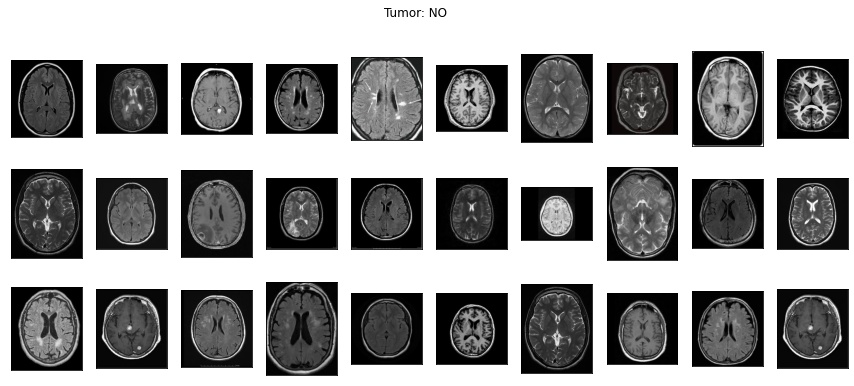

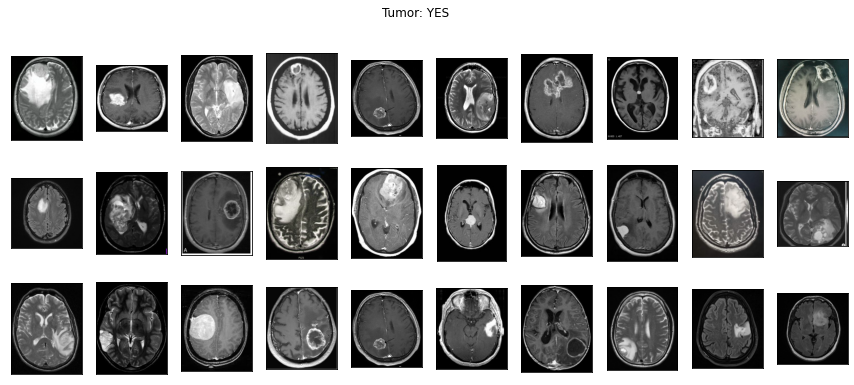

In [0]:
plot_samples(X_train, y_train, labels, 30)

Ces images ont une largeur et une hauteur différentes et une taille différente de "coins noirs". Étant donné que la taille d'image pour la couche imputée VGG-16 est (224,224), certaines images larges peuvent sembler étranges après le redimensionnement. Histogramme des distributions de ratios (ratio = largeur / hauteur):

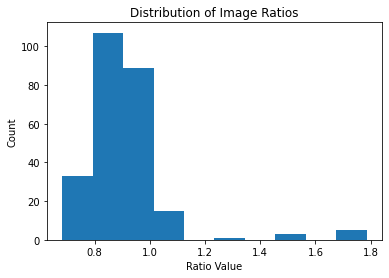

In [0]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

La première étape de la «normalisation» serait de rogner le cerveau des images. On a utilisé une technique qui était parfaitement décrite par pyimagesearch.

In [0]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

Visualisation de ce que cette fonction peut faire avec les examens IRM:

In [0]:
img = cv2.imread('/content/drive/My Drive/Colab Notebooks/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)
im_bw = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #ajout

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea) 

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

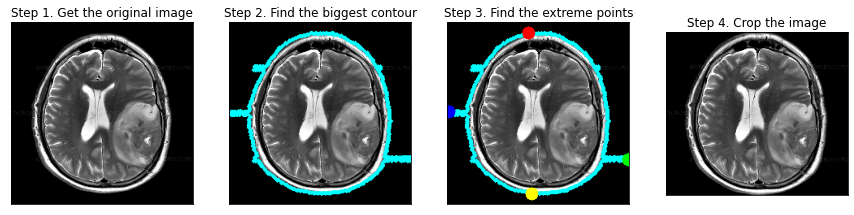

In [0]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

Application de cela pour chaque ensemble

In [0]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

Affichage

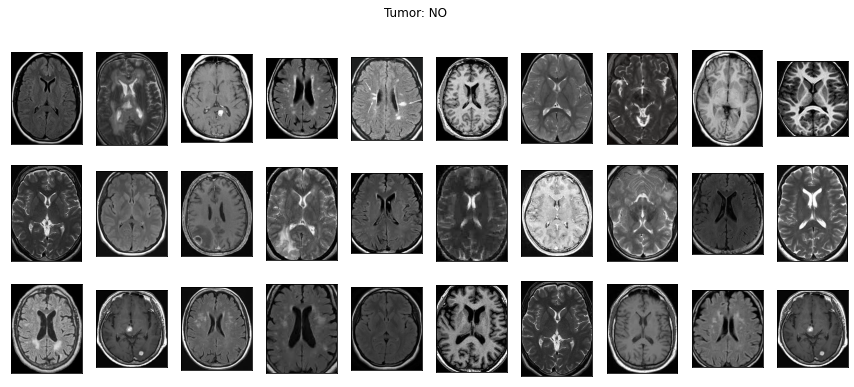

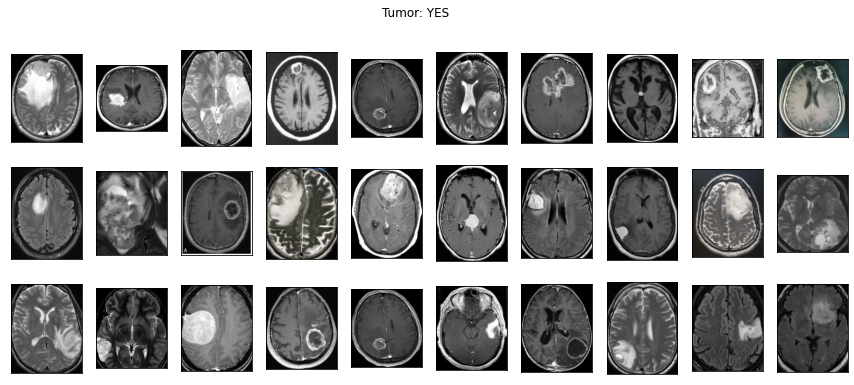

In [0]:
plot_samples(X_train_crop, y_train, labels, 30)

Enregistrement de nouvelles images dans le dossier

In [0]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [0]:
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘VAL_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/YES’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/NO’: File exists
mkdir: cannot create directory ‘TEST_CROP/YES’: File exists
mkdir: cannot create directory ‘TEST_CROP/NO’: File exists
mkdir: cannot create directory ‘VAL_CROP/YES’: File exists
mkdir: cannot create directory ‘VAL_CROP/NO’: File exists


Redimensionnement ldes images en (224, 224) et application du prétraitement nécessaire pour l'entrée du modèle VGG-16.

In [0]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [0]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

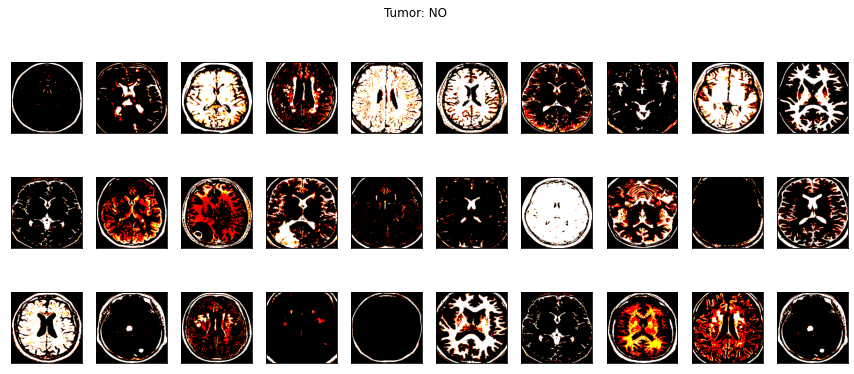

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

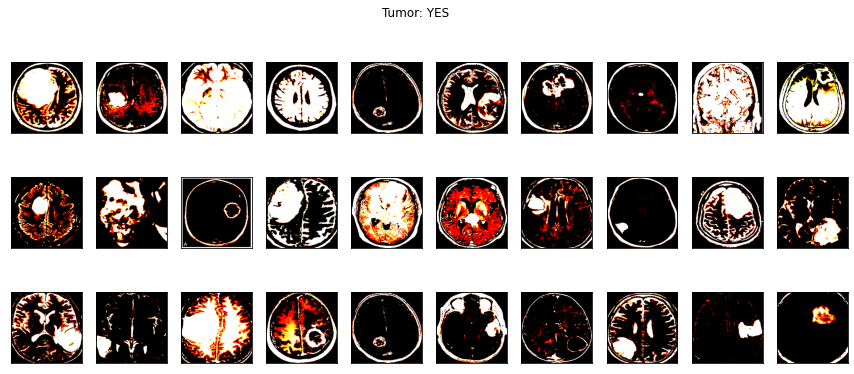

In [0]:
 plot_samples(X_train_prep, y_train, labels, 30)

## **[4. Modèle CNN](https://)**

On utilisait **Transfer Learning** avec l'architecture VGG-16 et les poids comme modèle de base.


Étant donné que notre ensemble de données était petit, on a utilisé la technique **Data Augmentation** afin d'augmenter la taille de l'ensemble d'entraînement.

Voilà l'exemple d'une image à quoi ressemble l'augmentation.

## **[Définission des paramètres qu'on veut modifier aléatoirement](https://)**

In [0]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [0]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

## **[Augmentatation du jeu de donnees](https://)**

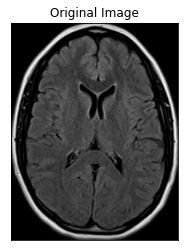

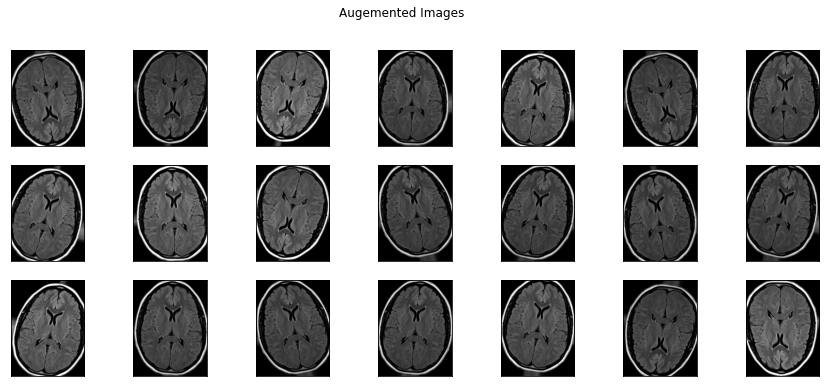

In [0]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [0]:
!rm -rf preview/

**[Application des donnees augmentees](https://)**

In [0]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## [Construction de notre modele](https://)

In [0]:
# Chargement du modele de base
vgg16_weight_path = '/content/drive/My Drive/Colab Notebooks/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [0]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


[Entrainnement de notre modele](https://)

Nous allons entrainer notre modele sur une periode de 30 epoques avec 50 etapes par epoque afin de trouver des resultats plus satisfaisants

In [0]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30
50/50 [==============================] - 871s 17s/step - loss: 4.2522 - accuracy: 0.5792 - val_loss: 1.9424 - val_accuracy: 0.7816
Epoch 2/30


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning:

Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy



50/50 [==============================] - 866s 17s/step - loss: 2.9939 - accuracy: 0.6949 - val_loss: 1.0373 - val_accuracy: 0.8386
Epoch 3/30
50/50 [==============================] - 852s 17s/step - loss: 2.5091 - accuracy: 0.7463 - val_loss: 1.3556 - val_accuracy: 0.8386
Epoch 4/30
50/50 [==============================] - 859s 17s/step - loss: 2.1361 - accuracy: 0.7636 - val_loss: 2.4326e-07 - val_accuracy: 0.8377
Epoch 5/30
50/50 [==============================] - 873s 17s/step - loss: 1.7467 - accuracy: 0.7816 - val_loss: 0.0512 - val_accuracy: 0.8861
Epoch 6/30
50/50 [==============================] - 873s 17s/step - loss: 1.7121 - accuracy: 0.8192 - val_loss: 0.3959 - val_accuracy: 0.8544
Epoch 7/30
50/50 [==============================] - 873s 17s/step - loss: 1.1566 - accuracy: 0.8453 - val_loss: 0.4898 - val_accuracy: 0.8259
Epoch 8/30
50/50 [==============================] - 856s 17s/step - loss: 1.2344 - accuracy: 0.8454 - val_loss: 3.2955e-09 - val_accuracy: 0.8576
Epoch 9/3

[Perfomance de notre modele](https://)

Représentation du modèle de tracé 

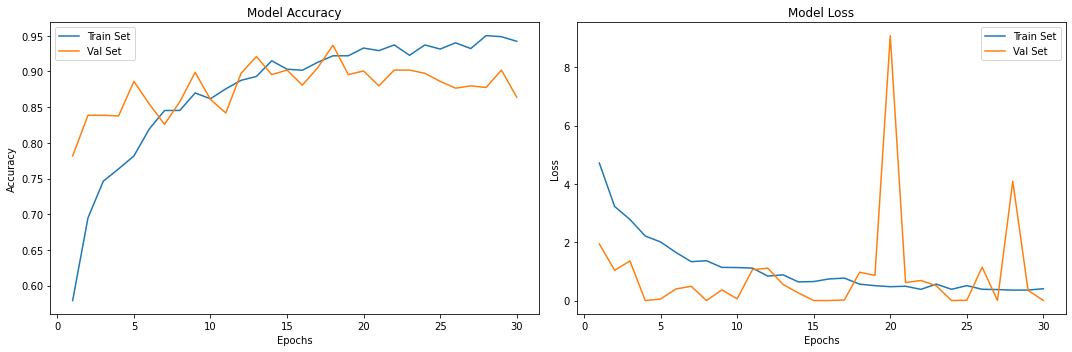

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## [Validation](https://)
Validation de notre modele sur val_set tout en affichant la matrice de confusion

Val Accuracy = 0.90


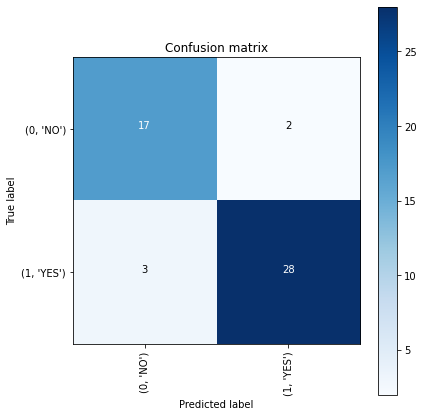

In [0]:
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Validation de notre modele sur test_set tout en affichant la matrice de confusion

Test Accuracy = 1.00


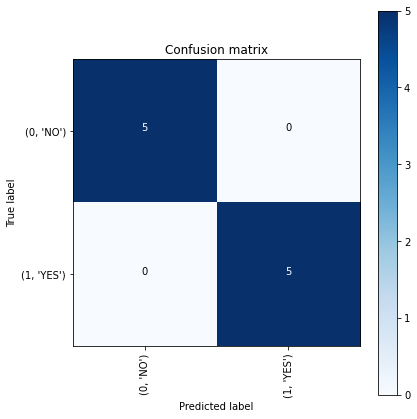

In [0]:
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Visualisation des images de l'ensemble de test qui ont été mal classées:

In [0]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('Pas d_images mal classées.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

Pas d_images mal classées.


# [5. Conclusions](https://)

Le but de ce projet était de combiner un problème de classification du modèle CNN (pour prédire si le sujet a une tumeur cérébrale ou non) et d'un problème de vision par ordinateur (pour automatiser le processus de recadrage cérébral à partir d'IRM). 

La précision finale est bien supérieure à la ligne de base de 50% (estimation aléatoire). Cependant, il pourrait être augmenté par un plus grand nombre d'images de **TRAIN** ou par le réglage des hyperparamètres du modèle.

Nettoyage de l'espace de travail et sauvegarde de notre modele

In [0]:
# Nettoyage
!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP
# enregistrement du modele
model.save('brain_VGG_model.h5')